<a href="https://colab.research.google.com/github/RafalDoroz/ai/blob/main/lime_nesnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1️⃣ Instalacja i import bibliotek
!pip install lime torchvision torch pillow matplotlib

import numpy as np
import torch
from torchvision import models, transforms
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from PIL import Image


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.8 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha2

In [2]:
# 2️⃣ Ładujemy wstępnie wytrenowany model ResNet18
model = models.resnet18(pretrained=True)
model.eval()

# 3️⃣ Przygotowujemy transformacje obrazu
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # standardowe wartości dla ImageNet
        std=[0.229, 0.224, 0.225]
    )
])


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 78.6MB/s]


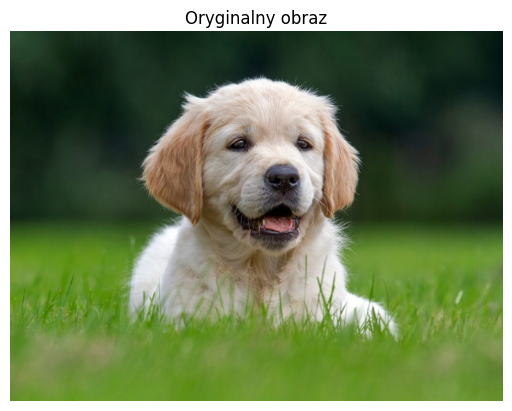

In [4]:
# 4️⃣ Wczytujemy przykładowy obraz
img_path = "dog.jpg"   # <- tu możesz wgrać własny obraz
img = Image.open(img_path)

plt.imshow(img)
plt.title("Oryginalny obraz")
plt.axis("off")
plt.show()

# 5️⃣ Konwersja obrazu do tensora
img_tensor = preprocess(img).unsqueeze(0)  # dodajemy wymiar batch


In [5]:
# 6️⃣ Tworzymy funkcję predykcji do użycia z LIME
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess(Image.fromarray(i)) for i in images), dim=0)
    logits = model(batch)
    probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.detach().numpy()


In [6]:
# 7️⃣ Inicjalizujemy explainer LIME
explainer = lime_image.LimeImageExplainer()

# 8️⃣ Wyjaśniamy predykcję modelu dla obrazu
explanation = explainer.explain_instance(
    np.array(img),
    batch_predict,
    top_labels=1,
    hide_color=0,
    num_samples=1000  # ile losowych perturbacji obrazu LIME wygeneruje
)


  0%|          | 0/1000 [00:00<?, ?it/s]

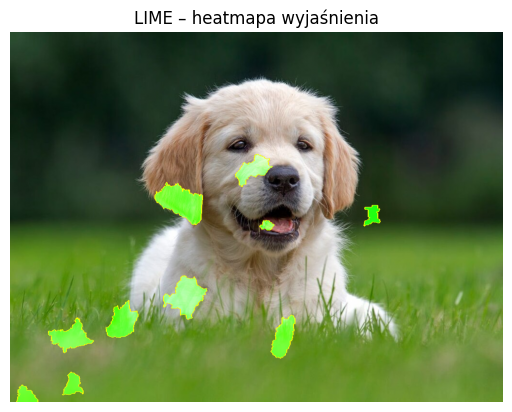

In [7]:
# 9️⃣ Generujemy heatmapę dla przewidywanej etykiety
from skimage.color import gray2rgb

temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=False,
    hide_rest=False,
    num_features=10,
    min_weight=0.0
)

plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title("LIME – heatmapa wyjaśnienia")
plt.axis("off")
plt.show()
